# Transfer Learning with MobileNetv2
- We'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier.
- A pre-trained model is a network that's already been trained on a large dataset and saved, which allows us to use it to customize our own model cheaply and efficiently. The one we'll be busing MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.
- We will be able to :
    - Create a dataset from a directory
    - Preprocess and augment data using the Sequential API
    - Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet.
    - Fine-tune a classifier's final layers to improve accuracy.

# 1. Packages

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## 1.1 Create the Dataset and Split it into Training and Validation sets
- When training and evaluating deep learning models in keras, generating a dataset from images files stored on disk is simple and fast. Call image_data_set_from_directory() to read from the directory and create both training and validation datasets.
- If we're specifying a validation split, we'll also need to specify the subset for each portion. Just set the training set to subset = 'training' and the validation set to subset='validation'.

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


- The original dataset had some mislabelled images in it as well.

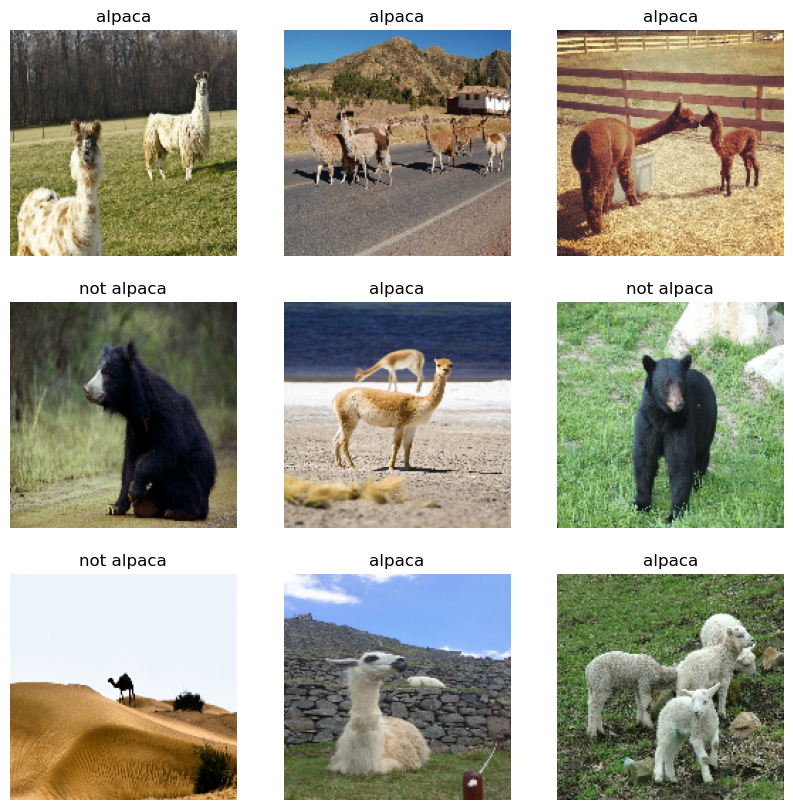

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2. Preprocess and Augment Training Data
- We may have encountered dataset.prefetch as an important extra setp in data preprocessing.
- Using prefetch() prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from our input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doen't need to fit into memory.
- We can set the number of elements to prefetch manually, or we can use tf.data.experimental.AUTOTUNE to choose the parameters automatically. Autotune prompts tf.data to tune that value dynamically at runtime, but tracking the time spent in each operation and feeding thoese times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.
- To increase diversity in the training set and help out model learn the data better, it's standard practice to augment the images by transforming them, i.e randomly flipping and rotating them. Keras Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of our model and can be re-used later.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

- Implemnt a function for data augmentation. Use Sequential keras model composed of 2 layers :
    - RandomFlip('horizontal')
    - RandomRotation(0.2)

In [7]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

- Take a look at how an image from the training set has been augmnted with simple transformations.
- From one cute animal to 9 variations of that cute animal.

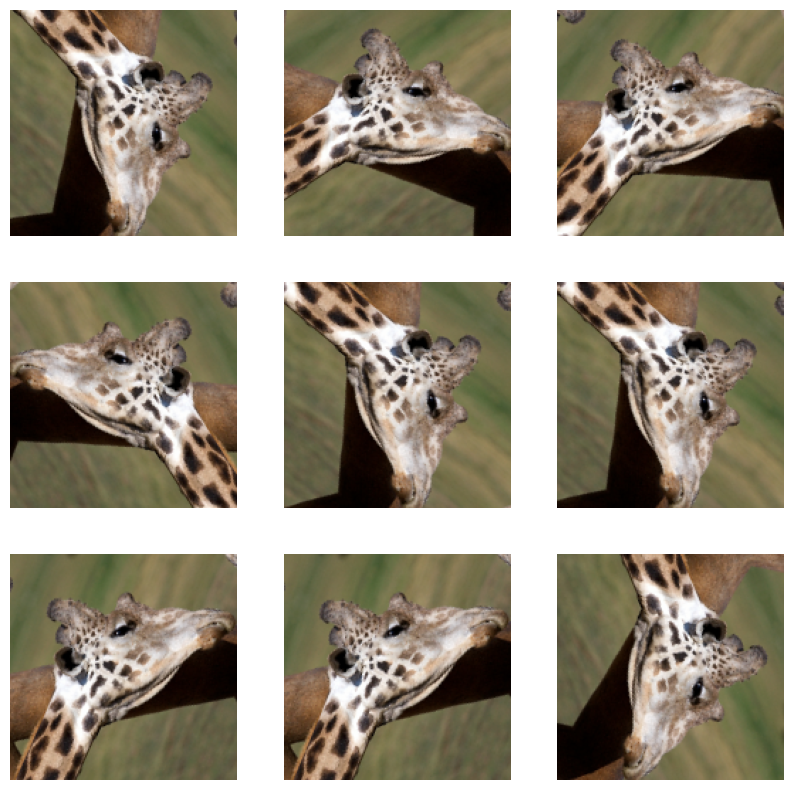

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augumented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augumented_image[0]/255)
        plt.axis('off')

- We will apply our first tool from the MobileNet application in TensorFlow, to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1, 1]. It's best practice to reuse the standard with tf.keras.applications.mobilenet_v2.preprocess_input.

- We should remember :
    - When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap.
    - Use prefetch() to prevent memory bottlenecks when reading from disk.
    - Give our model more to learn from with simple data augmentations like rotation and flipping.
    - When using a pretrained model, it's best to reuse the weights it was trained on.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 3. Using MobileNetV2 for Transfer Learning
- MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. Its 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has 3 defining characteristics : 
    - Depthwise seperable convolutions
    - Thin input and output bottlenecks b/w layers
    - Shortut connections b/w bottlneck layers

## 3.1 Inside a MobileNetV2 Convolutional Building Block
- MobileNetV2 uses depthwise seperable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in 2 steps :
    1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.
    2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution or:  Shape of the depthwise convolution X number of filters.
    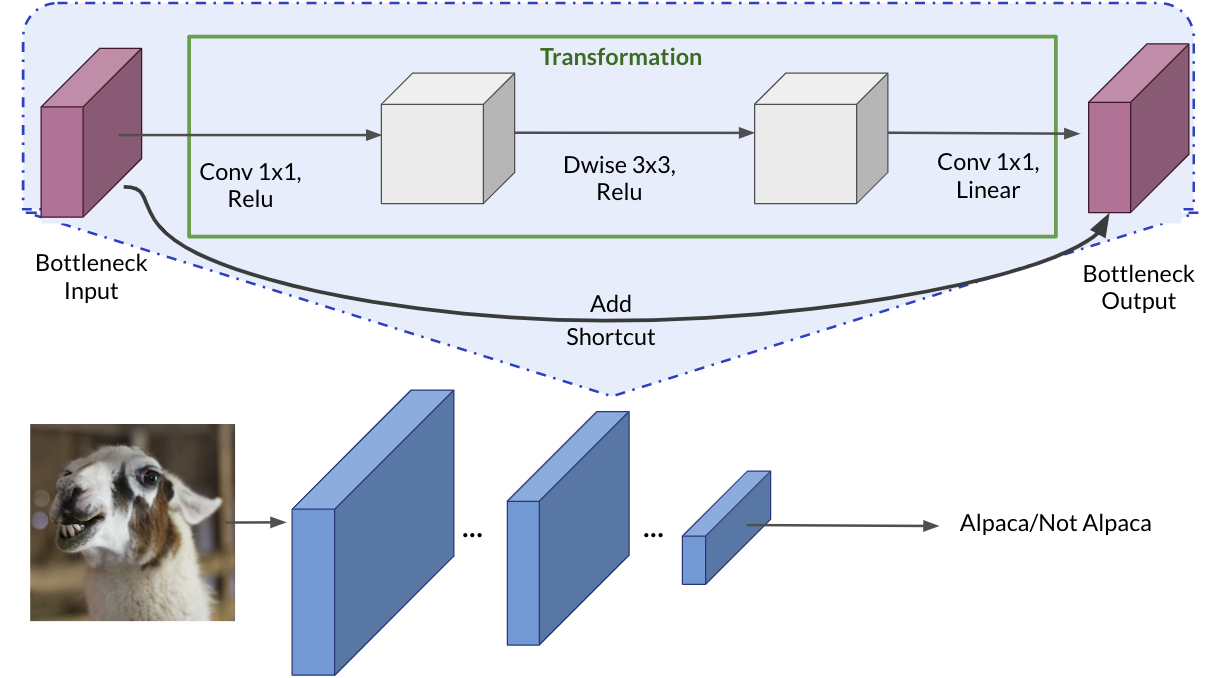
- Each block consists of an iverted residual structure with a bottleneck at each end. These bottleneck encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.
- The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottlneck layers.

- Let's try to train our base model using all the layers form the pretrained model.
- Similarly to how we reused the pretrained normalization values MobileNetV2 was trained on, we'll also load the pretrained weights from ImageNet.
- By specifying weights='imagenet', the weights are downloaded for ImageNet. 

In [11]:
IMG_SHAPE = IMG_SIZE + (3, )
base_model_path = "with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=True,
                                              weights=base_model_path)

- Print the model summary to see all the model's layers, the shapes of their outputs and the totol number of parameters trainable and non-trainable

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

- The last 2 layers are called top layers, and they are responsible of the classification in the model.

In [13]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers-2].name)
print(base_model.layers[nb_layers-1].name)

global_average_pooling2d
predictions


- Some of the layers in the summary like Conv2D and DepthwiseConv2D and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck layers

- MobileNetV2's unique features are :
    - Depthwise seperable convolutions that provide lightweight feature filtering and creation
    - Input and output bottlenecks that preserve important information on either end of the bottleneck
- Depthwise seperable convolutions deal with both spatial and depth (number of channels) dimensions.

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [16]:
# Show the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1])>

- Now decod the predictions made by the model. Earlier, when we printed the shape of the batch, it would have returned (32, 1000). The number 32 referes to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follows the format :
    - First the class number, then a human-readable format label, and last the probability of the image belonging to that class.

In [18]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

# Function to decode predictions
def decode_predictions(preds, top=2):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(class_index[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

with open("imagenet_class_index.json", 'r') as f:
    class_index = json.load(f)
    
decoded_predictions = decode_predictions(pred.numpy(), top=2)
print(decoded_predictions)

[[('n02454379', 'armadillo', 0.89280784), ('n02172182', 'dung_beetle', 0.024268974)], [('n02437312', 'Arabian_camel', 0.2954116), ('n02134084', 'ice_bear', 0.043125343)], [('n01616318', 'vulture', 0.07522374), ('n02130308', 'cheetah', 0.06773627)], [('n02437616', 'llama', 0.981389), ('n02437312', 'Arabian_camel', 0.00090887106)], [('n02483362', 'gibbon', 0.16563405), ('n02509815', 'lesser_panda', 0.10041619)], [('n02133161', 'American_black_bear', 0.8799118), ('n02132136', 'brown_bear', 0.019821735)], [('n01518878', 'ostrich', 0.95788085), ('n02018795', 'bustard', 0.002906945)], [('n02437616', 'llama', 0.7814681), ('n02098286', 'West_Highland_white_terrier', 0.043964203)], [('n02410509', 'bison', 0.4543146), ('n02132136', 'brown_bear', 0.4516914)], [('n02133161', 'American_black_bear', 0.69108677), ('n02132136', 'brown_bear', 0.08774367)], [('n01518878', 'ostrich', 0.87967294), ('n02018795', 'bustard', 0.007729871)], [('n02437616', 'llama', 0.4719322), ('n02417914', 'ibex', 0.21382436)

- There's a whole lot of labels here, some of them hilariously wrong, but none of them say 'alpaca'
- This is becuase MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is bunch of incorrectly classified images.
- We can delete the top layer, which contains all the classification labels and create a new classification layer.

## 3.2 Layer Freezing with the Functional API
- 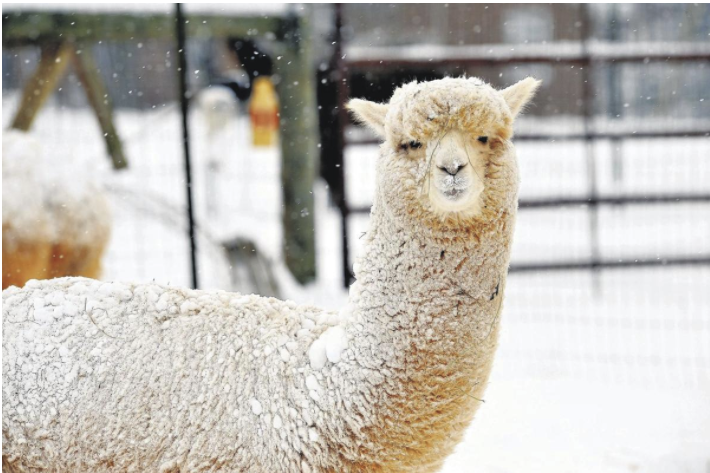
- We'll see how we can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. We can achieve this in 3 steps :
    1. Delete the top layer (the classification layer)
        - Set include_top in base_model as False
    2. Add a new classifier layer
        - Train only one layer by freezing the rest of the network
        - A single neuron is enough to slove a binary classification problem.
    3. Freeze the base model and train the newly-created classifier layer
        - Set base model.trainable = False to avoid changing the weights and train only the new layer
        - Set training in base_model to False to avoid keeping track of statistics in the batch norm layer

In [20]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model_path="without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights=base_model_path)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x =  tfl.GlobalAveragePooling2D ()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x =  tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one) 
    outputs = tfl.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [21]:
model2 = alpaca_model(IMG_SIZE)

In [23]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5



9/9 [==============================] - 7s 428ms/step - loss: 0.7925 - accuracy: 0.5229 - val_loss: 0.5742 - val_accuracy: 0.6923
Epoch 2/5
9/9 [==============================] - 3s 294ms/step - loss: 0.6309 - accuracy: 0.6374 - val_loss: 0.4763 - val_accuracy: 0.7231
Epoch 3/5
9/9 [==============================] - 3s 291ms/step - loss: 0.5601 - accuracy: 0.6298 - val_loss: 0.4126 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 3s 285ms/step - loss: 0.4339 - accuracy: 0.7595 - val_loss: 0.3327 - val_accuracy: 0.8462
Epoch 5/5
9/9 [==============================] - 3s 292ms/step - loss: 0.4213 - accuracy: 0.7939 - val_loss: 0.3057 - val_accuracy: 0.8462


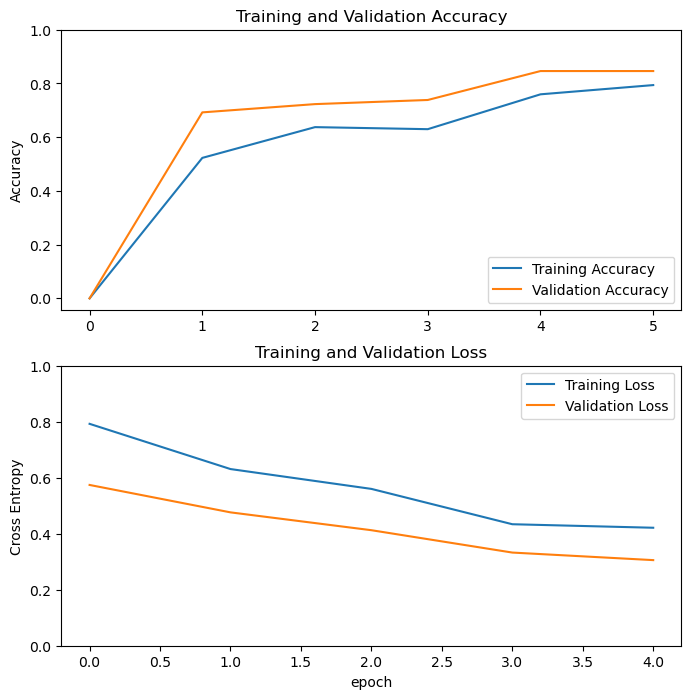

In [25]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
class_names

['alpaca', 'not alpaca']

## 3.3 Fine Tuning the Model
- We could try fine tunning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take smaller sets to adpat it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training our model on the final layers with a very low learning rate. Adapating our learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.
- The intution for what's happening : When the netwrk is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level featyres like wisp hair or pointy ears beginn to emerge. For transfer learning, the low-level features can be kepth the same, as they have common features for most images. When we add new data, we generally want the high-level features to adapat to it, which is rather like letting the network learn to detect features more related to our data, such as soft fur or big teeth.
- To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.
- Where the final layer actualy begin is a bit arbitrary, so feel free to lay aroung with this number a bit. The important takeway is that the later layers are the part of our network that contain the fine details that more specific to our problem.
- First, unfreze the base model by setting base_model.trainable=True, set a layer to fine-tune from, then re-freexe all the layers before it.

In [27]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [28]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 441ms/step - loss: 0.4721 - accuracy: 0.7481 - val_loss: 0.2635 - val_accuracy: 0.9385
Epoch 6/10
9/9 [==============================] - 3s 345ms/step - loss: 0.3125 - accuracy: 0.8702 - val_loss: 0.1740 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 4s 356ms/step - loss: 0.2635 - accuracy: 0.8931 - val_loss: 0.1051 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 4s 356ms/step - loss: 0.1720 - accuracy: 0.9122 - val_loss: 0.1013 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 4s 348ms/step - loss: 0.1665 - accuracy: 0.9389 - val_loss: 0.0745 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 4s 356ms/step - loss: 0.1268 - accuracy: 0.9504 - val_loss: 0.2013 - val_accuracy: 0.8308


In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

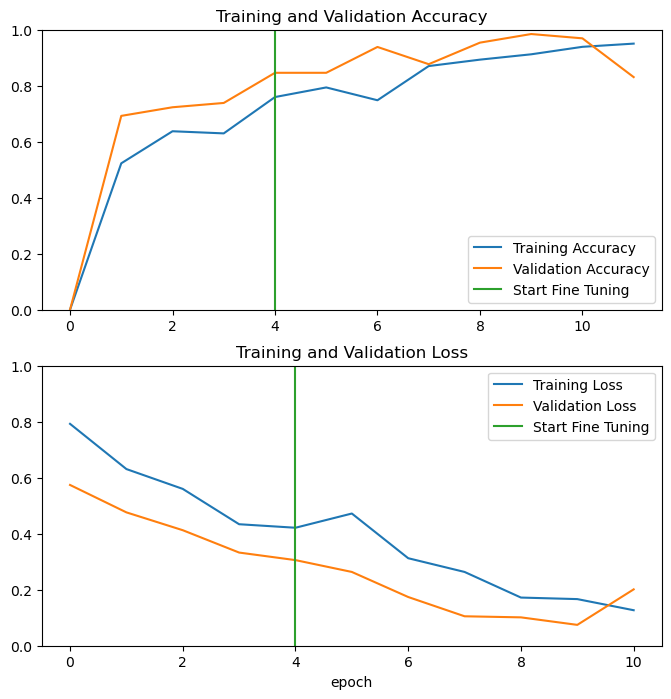

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

- To adapt the classifier to new data : Delete the top layer, add a new classifier layer, and train only on that layer.
- When freezing layers, avoid keeping track of statistics (like in batch normalization layer)
- Fine-tune the final layers of our model to capture high-level details near the end of the network and potentially improve accuracy